# estimate_ARparams_by_NNで推定した$F$を用いてwithoutDiscriminatorで$G$を学習

In [1]:
import argparse
import os
path = os.getcwd()
path=path[:path.find('estimate-innovation')+20]
# No = (os.path.basename(__file__))[-4]
No = "0" # notebook用
# print('実験No.'+No)
import warnings
warnings.simplefilter('ignore')# 警告を非表示
import numpy as np
np.set_printoptions(precision=4, floatmode='fixed', suppress=True)
import matplotlib.pyplot as plt
from scipy import stats
import math
import sys
sys.path.append(path)
import random
import time
import statsmodels.api as sm
from scipy.stats import norm
import japanize_matplotlib
from scipy.stats import gaussian_kde

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models
# p-Wasserstein距離の関数
import Wasserstein
path

'/home/lab/ryuichi/Documents/research/estimate-innovation/'

### ARモデルに従う時系列の作成（Fの学習と同じやつを使う）

In [2]:
phi_a = [1.0, -0.5, 0.7, -0.4]
phi_b = [0]
p = len(phi_a)
q = len(phi_b)
dataSeed=5
N = 1000
data = tsModel.ARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='normal')
inno = tsModel.ARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='normal', return_innovation=True)

### GPUが使えるかどうかを確認

In [3]:
import checkGPU
cuda, device = checkGPU.checkGPU()

GPUが使えます。
GPUを使いますか？ （Yes：1, No：0）： 0


### 推定に用いる$\hat p$を決定

In [4]:
hat_p = 4

### 学習曲線などの画像を保管するディレクトリと、NNのパラメータを保存するディレクトリを作成

In [5]:
os.makedirs("output-images/p{0}".format(hat_p), exist_ok=True)
os.makedirs("parameters/p{0}".format(hat_p), exist_ok=True)

### NNを学習する時のハイパラを決定する

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument("--generator_seed", type=int, default=0, help="generatorのパラメータの初期値のシード")
parser.add_argument("--predictor_seed", type=int, default=0, help="predictorのパラメータの初期値のシード")
parser.add_argument("--batch_size", type=int, default=1, help="batchの大きさ")
parser.add_argument("--n_epochs", type=int, default=1000, help="学習させる回数")
parser.add_argument("--lamda", type=float, default=1.0, help="mseに対するWasserstein損失の割合（正則化係数）")
# opt = parser.parse_args() # .pyの場合はこちらを使用(.ipynbの場合エラーになります)
opt = parser.parse_args(args=[]) # .ipynbの場合はこちらを使用

### NNモデルを作成($F$は学習済の$F$を読み込む)

In [7]:
predictor = models.LinearPredictNet(input_size=hat_p+1)
preF_paramPath = path+"checkAR/parameters/p{0}/preLinearPredictor.pth".format(hat_p)
predictor.load_state_dict(torch.load(preF_paramPath))
predictor = predictor.to(device)

torch.manual_seed(opt.generator_seed)
generator = models.LinearGenerator(input_size = hat_p+1)
generator = generator.to(device)

### $\varepsilon$からの重さを1にする

In [8]:
predictor.fc1.weight.data[0][0] = 1

In [9]:
predictor.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 1.0000, -0.4017,  0.7122, -0.5019,  1.0023]]))])

### 学習データとvalidationデータを分ける（9:1）

In [10]:
trainData = data[:N//10*9]
valData = data[N//10*9:]

### データローダの作成

In [11]:
import my_preprocess
train_dataset = my_preprocess.DataSet(tsData=trainData, hat_p=hat_p, device=device)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True, drop_last=True)
val_dataset = my_preprocess.DataSet(tsData=valData, hat_p=hat_p, device=device)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, drop_last=True)

### 最適化手法の設定

In [12]:
optimizer_F = torch.optim.Adam(params=predictor.parameters(), lr=0.0001 )
optimizer_G = torch.optim.Adam(params=generator.parameters(), lr=0.0001 )
# optimizer_F = torch.optim.SGD(params=predictor.parameters(), lr = 0.00005)

### Lossの設計

In [13]:
mseLoss = nn.MSELoss()
mseLoss = mseLoss.to(device)
# Variable(Wasserstein.pWasserstein(hat_normeps_t.view(opt.batch_size), p=1), requires_grad=True).to(device)

### 学習に必要なリスト

In [14]:
train_lossList_mse = []
val_lossList_mse = []
train_lossList_Wasser = []
val_lossList_Wasser = []

### 学習

学習プランは、
- Gのパラメタ更新をONに、FはOFF
- Loss = Wasserstein + mseとしてGを学習
- しばらく学習したら、今度はFも更新可能にして学習

In [15]:
minLoss = np.inf
paramPath_F = path+"checkAR/parameters/p{0}/LinearPredictor.pth".format(hat_p)
paramPath_G = path+"checkAR/parameters/p{0}/LinearGenerator.pth".format(hat_p)

start = time.time()

for param in generator.parameters(): # generatorの勾配の更新をONにする
    param.requires_grad = True 
for param in predictor.parameters(): # predictorの勾配の更新をOFFにする
    param.requires_grad = False
PredictorTrainFlag = False
    
for epoch in range( opt.n_epochs):# epochごとの処理
    
    # たまにPredictorも学習する（勾配の更新を許可する）
    if epoch%10==10-1:
        PredictorTrainFlag = True
        for param in predictor.parameters():
            param.requires_grad = True
    
    train_epoch_loss_mse = 0 # itelationごとに出力されるLossのbatch平均を足しこむ変数（あとでitelationの回数で割ってlossListにappendする）
    train_epoch_loss_Wasser = 0
    for idx, (X, Y) in enumerate(train_dataloader):
        X=X.to(device)
        Y=Y.to(device)
        """
        Generatorの学習
        """
        train_input_tensor_G = torch.cat([X, Y.view([-1,1])], axis=1)
        train_output_tensor_G = generator(train_input_tensor_G)
        train_input_tensor_F = torch.cat([train_output_tensor_G, X], axis=1)# ランダムな次元を追加
        train_output_tensor_F = predictor(train_input_tensor_F)
            
        Wasser_loss = Variable(Wasserstein.pWasserstein(train_output_tensor_G, p=1, device=device), requires_grad=True)
        mse_loss = mseLoss(train_output_tensor_F, Y.to(device))
        train_loss =  opt.lamda*Wasser_loss + mse_loss 
        
        train_loss.backward()# 勾配をとる
        optimizer_G.step()# 勾配情報と最適化手法を元にparameterを更新
        optimizer_G.zero_grad()
        
        # もしPredictorも学習するならしないとね
        if PredictorTrainFlag:
            optimizer_F.step()
            optimizer_F.zero_grad()
        
        train_epoch_loss_mse += mse_loss.item()
        train_epoch_loss_Wasser += Wasser_loss.item()
    train_lossList_mse.append(train_epoch_loss_mse/(idx+1))
    train_lossList_Wasser.append(train_epoch_loss_Wasser/(idx+1))
   
    # そして再び不許可に。
    if PredictorTrainFlag:
        for param in predictor.parameters():
            param.requires_grad = False
        PredictorTrainFlag=False

    val_epoch_loss_mse = 0 # itelationごとに出力されるLossのbatch平均を足しこむ変数（あとでitelationの回数で割ってlossListにappendする）
    val_epoch_loss_Wasser = 0
    for idx, (X, Y) in enumerate(val_dataloader):
        X=X.to(device)
        Y=Y.to(device)
        """
        Generatorの学習のvalidationの推移
        """
        val_input_tensor_G = torch.cat([X, Y.view([-1,1])], axis=1)
        val_output_tensor_G = generator(val_input_tensor_G)
        val_input_tensor_F = torch.cat([val_output_tensor_G, X], axis=1)# ランダムな次元を追加
        val_output_tensor_F = predictor(val_input_tensor_F)
            
        Wasser_loss = Variable(Wasserstein.pWasserstein(val_output_tensor_G, p=1, device=device), requires_grad=True)
        mse_loss = mseLoss(val_output_tensor_F, Y.to(device))
        val_loss =  opt.lamda*Wasser_loss + mse_loss 
        
        val_epoch_loss_mse += mse_loss.item()
        val_epoch_loss_Wasser += Wasser_loss.item()
    val_lossList_mse.append(val_epoch_loss_mse/(idx+1))
    val_lossList_Wasser.append(val_epoch_loss_Wasser/(idx+1))
    
    
    if minLoss>val_lossList_mse[-1] + val_lossList_Wasser[-1]:
        minLoss = val_lossList_mse[-1] + val_lossList_Wasser[-1]
        torch.save(generator.state_dict(), paramPath_G)
        torch.save(predictor.state_dict(), paramPath_F)
        
#     break
    if epoch%100==100-1:
        print("epoch：{0}/{1}   val_loss_mse：{2: .4g}  val_loss_Wasser:{3: .4g}   経過時間：{4: .1f}秒".format(epoch+1, opt.n_epochs, val_lossList_mse[-1], val_lossList_Wasser[-1], time.time()-start))

            

epoch：100/1000   val_loss_mse： 1.045e-12  val_loss_Wasser: 1.081   経過時間： 208.9秒
epoch：200/1000   val_loss_mse： 1.046e-10  val_loss_Wasser: 1.081   経過時間： 418.0秒
epoch：300/1000   val_loss_mse： 2.918e-09  val_loss_Wasser: 1.082   経過時間： 627.1秒
epoch：400/1000   val_loss_mse： 1.045e-13  val_loss_Wasser: 1.082   経過時間： 836.1秒
epoch：500/1000   val_loss_mse： 4.785e-10  val_loss_Wasser: 1.082   経過時間： 1044.8秒
epoch：600/1000   val_loss_mse： 2.44e-12  val_loss_Wasser: 1.082   経過時間： 1254.7秒
epoch：700/1000   val_loss_mse： 1.141e-13  val_loss_Wasser: 1.083   経過時間： 1467.4秒
epoch：800/1000   val_loss_mse： 2.947e-09  val_loss_Wasser: 1.082   経過時間： 1677.0秒
epoch：900/1000   val_loss_mse： 2.817e-09  val_loss_Wasser: 1.083   経過時間： 1886.1秒
epoch：1000/1000   val_loss_mse： 1.569e-08  val_loss_Wasser: 1.082   経過時間： 2095.9秒


In [16]:
generator.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.3343, -0.5531,  0.3960, -0.8204,  0.8608]]))])

In [17]:
predictor.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 1.1617, -0.3883,  0.6426, -0.4599,  0.9531]]))])

In [18]:
predictor.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 1.1617, -0.3883,  0.6426, -0.4599,  0.9531]]))])

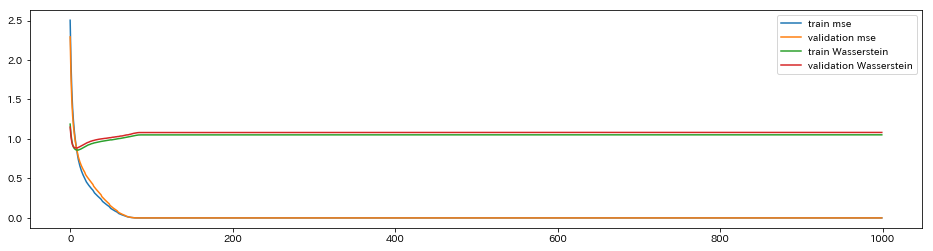

In [19]:
plt.figure(figsize=(16,4))
plt.plot(train_lossList_mse, label="train mse")
plt.plot(val_lossList_mse, label="validation mse")
plt.plot(train_lossList_Wasser, label="train Wasserstein")
plt.plot(val_lossList_Wasser, label="validation Wasserstein")
plt.legend()

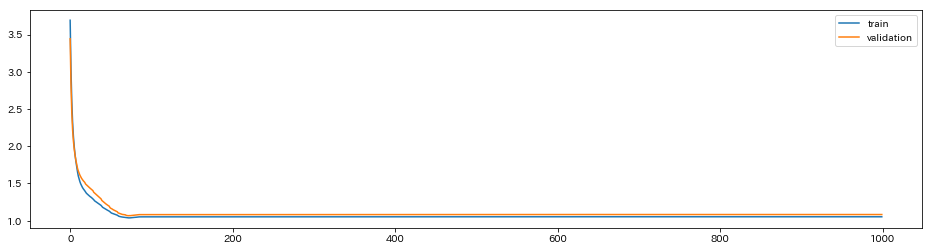

In [20]:
plt.figure(figsize=(16,4))
plt.plot(np.array(train_lossList_mse) + np.array(train_lossList_Wasser), label="train")
plt.plot(np.array(val_lossList_mse) + np.array(val_lossList_Wasser), label="validation")
plt.legend()

In [21]:
predictor.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 1.1617, -0.3883,  0.6426, -0.4599,  0.9531]]))])

In [22]:
generator.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.3343, -0.5531,  0.3960, -0.8204,  0.8608]]))])